<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/Lecture_15/Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.fft import fft2, ifft2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001
noise_factor = 0.5

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the Autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noise = torch.randn(img.size()).to(device) * noise_factor
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        # Forward pass
        output = model(noisy_img)
        loss = criterion(output, noisy_img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.12MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.95MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 0.0950
Epoch [2/10], Loss: 0.0924
Epoch [3/10], Loss: 0.0886
Epoch [4/10], Loss: 0.0866
Epoch [5/10], Loss: 0.0856
Epoch [6/10], Loss: 0.0868
Epoch [7/10], Loss: 0.0865
Epoch [8/10], Loss: 0.0873
Epoch [9/10], Loss: 0.0845
Epoch [10/10], Loss: 0.0885


In [2]:
# Function to add noise to an image
def add_noise(img, noise_factor=0.5):
    noise = torch.randn(img.size()).to(device) * noise_factor
    noisy_img = img + noise
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img

# Function to denoise using Gaussian filter
def gaussian_filter(img, kernel_size=5, sigma=1.0):
    img_np = img.squeeze().cpu().numpy()
    img_denoised = cv2.GaussianBlur(img_np, (kernel_size, kernel_size), sigma)
    return torch.tensor(img_denoised)

# Function to denoise using Fourier transform
def fourier_transform(img):
    img_np = img.squeeze().cpu().numpy().reshape(28, 28)  # Reshape to 2D
    f = fft2(img_np)
    f_shifted = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(f_shifted) + 1)

    # Apply a low-pass filter in the frequency domain
    rows, cols = img_np.shape
    crow, ccol = rows // 2, cols // 2
    f_shifted[crow-30:crow+30, ccol-30:ccol+30] = 0

    f_ishifted = np.fft.ifftshift(f_shifted)
    img_back = ifft2(f_ishifted)
    img_back = np.abs(img_back)
    return torch.tensor(img_back.reshape(1, -1))  # Reshape back to 1D

# Function to denoise using Median filter
def median_filter(img, kernel_size=3):
    img_np = img.squeeze().cpu().numpy()
    img_denoised = cv2.medianBlur(img_np, kernel_size)
    return torch.tensor(img_denoised)

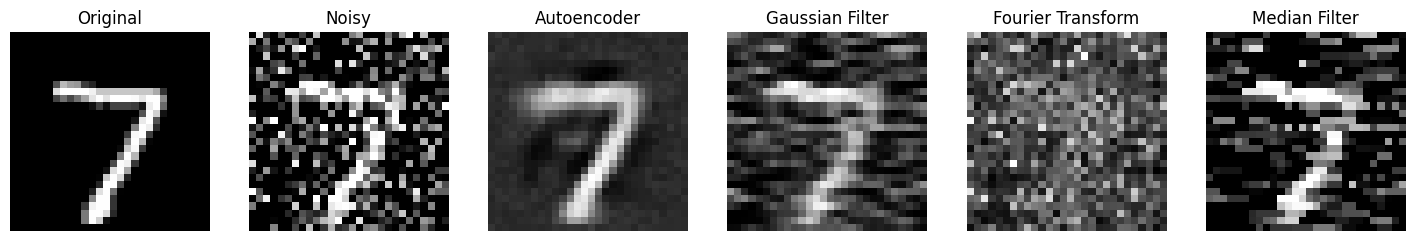

In [3]:
# Test the model on a sample image
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

for data in test_loader:
    img, _ = data
    img = img.view(img.size(0), -1).to(device)
    noisy_img = add_noise(img).to(device)

    # Denoise using Autoencoder
    denoised_img_ae = model(noisy_img).detach().cpu().view(28, 28)

    # Denoise using Gaussian filter
    denoised_img_gaussian = gaussian_filter(noisy_img).view(28, 28)

    # Denoise using Fourier transform
    denoised_img_fourier = fourier_transform(noisy_img).view(28, 28)

    # Denoise using Median filter
    denoised_img_median = median_filter(noisy_img).view(28, 28)

    # Plot the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 6, 1)
    plt.title('Original')
    plt.imshow(img.view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title('Noisy')
    plt.imshow(noisy_img.view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.title('Autoencoder')
    plt.imshow(denoised_img_ae.numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.title('Gaussian Filter')
    plt.imshow(denoised_img_gaussian.numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.title('Fourier Transform')
    plt.imshow(denoised_img_fourier.numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.title('Median Filter')
    plt.imshow(denoised_img_median.numpy(), cmap='gray')
    plt.axis('off')

    plt.show()

    break  # Just show one example